In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from time_series_service import series_to_supervised

In [2]:
# Read and prepare data to linear regression model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df[['DateTime', 'Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 2020-07-01 to 2021-06-26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Compound  361 non-null    float64
 1   Price     360 non-null    float64
dtypes: float64(2)
memory usage: 8.5+ KB


,Compound,Price
DateTime,,
2020-07-01,0.0,144.8
2020-07-02,0.0,18.0
2020-07-03,0.0,-67.3
2020-07-04,0.0,53.4
2020-07-05,0.0,-258.0


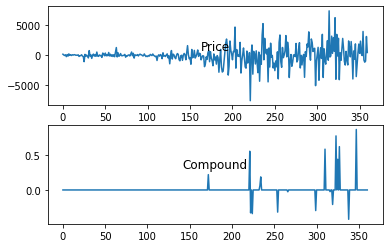

In [3]:
# Plot the time series of all features

columns_groups = [0,1]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

i = 1
plt.figure()
for column_group in columns_groups:
    plt.subplot(len(columns_groups), 1, i)
    plt.plot(df.values[:, column_group])
    plt.title(df.columns[column_group], y=0.5, loc='center')
    i += 1
plt.show()

In [4]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 1
n_obs = n_days * n_features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

reframed = series_to_supervised(scaled, n_days, 1)
reframed = reframed.drop(reframed.columns[-1:], axis=1)

reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.517534,0.326643,0.508997
2,0.508997,0.326643,0.503255
3,0.503255,0.326643,0.511381
4,0.511381,0.326643,0.490417
5,0.490417,0.326643,0.513373


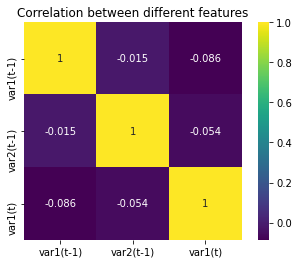

In [5]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different features')
plt.show();

In [6]:
# Split train and test data

non_zero_condition = reframed['var2(t-1)'].round(4) != 0.3266

zeros_df = reframed[~non_zero_condition]
non_zeros_df = reframed[non_zero_condition]

zeros_train_size = 0.7
non_zeros_train_size = 0.75

zeros_n_train_days = int(len(zeros_df)*zeros_train_size)
zeros_n_test_days =len(zeros_df) - zeros_n_train_days
non_zeros_n_train_days = int(len(non_zeros_df)*non_zeros_train_size)
non_zeros_n_test_days = len(non_zeros_df) - non_zeros_n_train_days

non_zero_test_step = int(len(non_zeros_df)/non_zeros_n_test_days)
zero_test_step = int(len(zeros_df)/zeros_n_test_days)

non_zero_test = non_zeros_df[::non_zero_test_step]
non_zero_train = pd.merge(non_zeros_df,non_zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

zero_test = zeros_df[::zero_test_step]
zero_train = pd.merge(zeros_df,zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

train = shuffle(pd.concat((non_zero_train, zero_train))).values
test = shuffle(pd.concat((non_zero_test, zero_test))).values

print(train.shape)

train_X, train_y = train[:, :n_obs], train[:, 2]
test_X, test_y = test[:, :n_obs], test[:, 2]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(239, 3)
(239, 1, 1) (239,) (120, 1, 1) (120,)


Epoch 1/10
60/60 - 2s - loss: 0.4116 - val_loss: 0.3476
Epoch 2/10
60/60 - 0s - loss: 0.2708 - val_loss: 0.1971
Epoch 3/10
60/60 - 0s - loss: 0.1237 - val_loss: 0.0743
Epoch 4/10
60/60 - 0s - loss: 0.0701 - val_loss: 0.0724
Epoch 5/10
60/60 - 0s - loss: 0.0691 - val_loss: 0.0722
Epoch 6/10
60/60 - 0s - loss: 0.0689 - val_loss: 0.0720
Epoch 7/10
60/60 - 0s - loss: 0.0687 - val_loss: 0.0718
Epoch 8/10
60/60 - 0s - loss: 0.0685 - val_loss: 0.0715
Epoch 9/10
60/60 - 0s - loss: 0.0683 - val_loss: 0.0713
Epoch 10/10
60/60 - 0s - loss: 0.0681 - val_loss: 0.0711


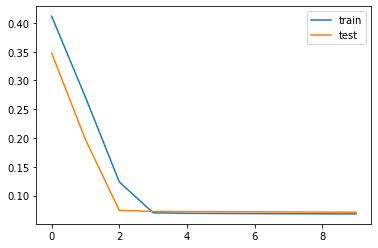

In [7]:
# Create the LSTM model, train it and plot the value loss

model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=10, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# Make predictions

predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days * n_features))

inv_predictions = np.concatenate((predictions, test_X), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

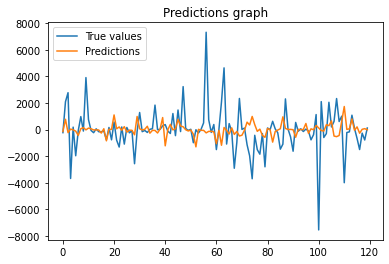

In [9]:
# Plot Results

plt.plot(inv_y, label="True values")
plt.plot(inv_predictions, label="Predictions")
plt.title("Predictions graph")
plt.legend(loc="upper left")

plt.show()

In [10]:
# Print the results

mse = mean_squared_error(inv_y, inv_predictions)
r2 = r2_score(inv_y, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): -0.13444060367750743
Mean Squared Error (MSE): 3010498.8829597095
Root Mean Square Error: 1735.079


In [11]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_y})
df_sol.to_csv('generated/predictions_sv_lstm.csv')